1. Figuring out feature importance
2. K-Nearest Neighbors 
    - Football Stats
    - Socioeconomic stats
    - Combination of both (from 1.)
3. Figure out best N with loop
4. Plot confusion matrix

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from copy import copy


In [2]:
# read data
df_total = pd.read_csv('df_matchup_total.csv')
df_total = df_total.iloc[:, 1:]

# rename columns
new_cols = {'Team': 'team', 
            'Year': 'year', 
            'Round': 'round ', 
            'Goals / 90': 'goals_p_90', 
            'Opponent Goals / 90': 'opp_goals_p_90',
            'Goals / 90 Difference': 'goals_90_dif', 
            'Assists / 90': 'assists_p_90', 
            'Opponent Assists / 90': 'opp_assists_p_90',
            'Assists / 90 Difference': 'assists_90_dif', 
            'Goals Minus Penalty Kicks / 90': 'goal_minus_penalty_90',
            'Opponent Goals Minus Penalty Kicks / 90': 'opp_goal_minus_penalty_90',
            'Goals Minus Penalty Kicks / 90 Difference': 'goal_minus_penalty_90_dif',
            'GDP Per Capita': 'gpd_cap',
            'GDP Growth Rate (%)': 'gdp_growth', 
            'Population Density': 'pop_density',
            'Population Density Growth Rate (%)': 'pop_density_growth', 
            'Life Expectancy': 'life_exp',
            'Life Expectancy Growth Rate (%)': 'life_exp_growth', 
            'Birth Rate': 'birth_rate',
            'Birth Rate Growth Rate (%)': 'birth_rate_growth', 
            'Death Rate': 'death_rate',
            'Death Rate Growth Rate (%)': 'death_rate_growth', 
            'Unemployment Rate': 'unemp_rate',
            'Opponent GDP Per Capita': 'opp_gdp_cap', 
            'GDP Per Capita Difference': 'gdp_per_cap_dif',
            'Opponent GDP Growth Rate (%)': 'opp_gdp_growth', 
            'GDP Growth Rate (%) Difference': 'gdp_growth_dif',
            'Opponent Population Density': 'opp_pop_density', 
            'Population Density Difference': 'pop_density_dif',
            'Opponent Population Density Growth Rate (%)': 'opp_pop_density_growth',
            'Population Density Growth Rate (%) Difference': 'pop_growth_dif',
            'Opponent Life Expectancy': 'opp_life_exp', 
            'Life Expectancy Difference': 'life_exp_dif',
            'Opponent Life Expectancy Growth Rate (%)': 'opp_life_exp_growth',
            'Life Expectancy Growth Rate (%) Difference': 'life_exp_growth_dif', 
            'Opponent Birth Rate': 'opp_birth_rate',
            'Birth Rate Difference': 'birth_rate_dif', 
            'Opponent Birth Rate Growth Rate (%)': 'opp_birth_rate_growth',
            'Birth Rate Growth Rate (%) Difference': 'birth_rate_growth_dif', 
            'Opponent Death Rate': 'opp_death_rate',
            'Death Rate Difference': 'death_rate_dif', 
            'Opponent Death Rate Growth Rate (%)': 'opp_death_rate_growth',
            'Death Rate Growth Rate (%) Difference': 'death_rate_growth_diff', 
            'Opponent Unemployment Rate': 'opp_unemp_rate',
            'Unemployment Rate Difference': 'unep_rate_dif', 
            'Result': 'result'}

df_total = df_total.rename(columns=new_cols)

# drop na's
df_total = df_total.dropna(how='any')

# remove draws
df_total = df_total[df_total['result'] != 'DRAW']
# df_total = df_total[df_total['Result'] != 'DRAW']


In [6]:
# ['Goals Minus Penalty Kicks / 90 Difference',
# 'Goals / 90 Difference',
# 'Goals / 90',
# 'Opponent Goals / 90',
# 'Goals Minus Penalty Kicks / 90',
# 'Opponent Goals Minus Penalty Kicks / 90',
# 'Assists / 90 Difference',
# 'Population Density Growth Rate (%) Difference',
# 'GDP Growth Rate (%) Difference',
# 'GDP Per Capita Difference']

# Random Forest Classifier & Feature Importance

In [7]:
def rf_cross_val(df, x_feat_list, target_feat, max_depth=3, n_splits=10):
    """ creates a RandomForestClassifier object and 
            cross validates
    
    Args:
        df (DataFrame): features and target feature data
        x_feat_list (list): list of features
        target_feat (str): target feature
        max_depth (int): maximum depth of tree 
        n_splits (int): number of splits for cross-validation
        
    Returns:
        y (np.array): true values
        y_pred (np.array): predicted values
        rand_forest_clf (RandomForestClassifier): random forest 
            classifier object
    """ 
    # extract data from dataframe
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, target_feat].values

    # fit the model
    rand_forest_clf = RandomForestClassifier(max_depth=max_depth)
    rand_forest_clf = rand_forest_clf.fit(x, y)

    # construction of kfold object
    kfold = KFold(n_splits=n_splits)

    # allocate an empty array to store predictions in
    y_pred = copy(y)

    # cross-validation
    for train_idx, test_idx in kfold.split(x, y):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y[train_idx]

        # fit 
        rand_forest_clf.fit(x_train, y_true_train)

        # estimate 
        y_pred[test_idx] = rand_forest_clf.predict(x_test)
        
    return y, y_pred, rand_forest_clf

In [8]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
#     plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.gcf().set_size_inches(15, 10)
    plt.title('Feature Importance', fontdict={'fontsize': 14})
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')


In [9]:
# scale normalization
for col in df_total.columns[3:-1]:
    df_total[col] = df_total[col] / df_total[col].std()
    
    
# params
x_feat_list = df_total.columns[3:-1]
# x_feat_list = ['goal_minus_penalty_90_dif', 
# 'goals_90_dif',
# 'goals_p_90',
# 'opp_goals_p_90',
# 'goal_minus_penalty_90', 
# 'opp_goal_minus_penalty_90',
# 'assists_90_dif',
# 'pop_growth_dif',
# 'gdp_growth_dif',
# 'gdp_per_cap_dif']

# x_feat_list = ['Goals Minus Penalty Kicks / 90 Difference',
# 'Goals / 90 Difference',
# 'Goals / 90',
# 'Opponent Goals / 90',
# 'Goals Minus Penalty Kicks / 90',
# 'Opponent Goals Minus Penalty Kicks / 90',
# 'Assists / 90 Difference',
# 'Population Density Growth Rate (%) Difference',
# 'GDP Growth Rate (%) Difference',
# 'GDP Per Capita Difference']

target_feat = 'result'
# target_feat = 'Result'

# random forest classification
y, y_pred, rand_forest_clf = rf_cross_val(df_total, x_feat_list, target_feat);

In [10]:
import operator

top_feats = {feat: imp for feat, imp in zip(x_feat_list, rand_forest_clf.feature_importances_)}
sorted_feats = dict(sorted(top_feats.items(), key=operator.itemgetter(1),reverse=True))
sorted_feats

{'goals_90_dif': 0.19309618979327312,
 'goal_minus_penalty_90_dif': 0.14139181677576992,
 'goal_minus_penalty_90': 0.09282280553057758,
 'opp_goal_minus_penalty_90': 0.07425327662975424,
 'assists_90_dif': 0.05959960043890849,
 'goals_p_90': 0.048832932115713525,
 'opp_goals_p_90': 0.04288039067378188,
 'pop_density_growth': 0.029072253335270023,
 'opp_pop_density_growth': 0.027075536923901636,
 'birth_rate_dif': 0.021131337077172078,
 'life_exp_dif': 0.01927976448852909,
 'gdp_growth_dif': 0.01602732837934702,
 'assists_p_90': 0.013776051392838615,
 'life_exp_growth_dif': 0.012887473199896192,
 'death_rate_growth': 0.012506715775282758,
 'birth_rate_growth_dif': 0.012313274002429613,
 'pop_growth_dif': 0.012247601692727761,
 'gpd_cap': 0.012085031528448222,
 'unep_rate_dif': 0.011152726926515508,
 'opp_birth_rate': 0.01010340665792426,
 'opp_life_exp': 0.01004403892329801,
 'opp_assists_p_90': 0.009848820461173292,
 'birth_rate_growth': 0.00968717818430833,
 'opp_gdp_growth': 0.008909

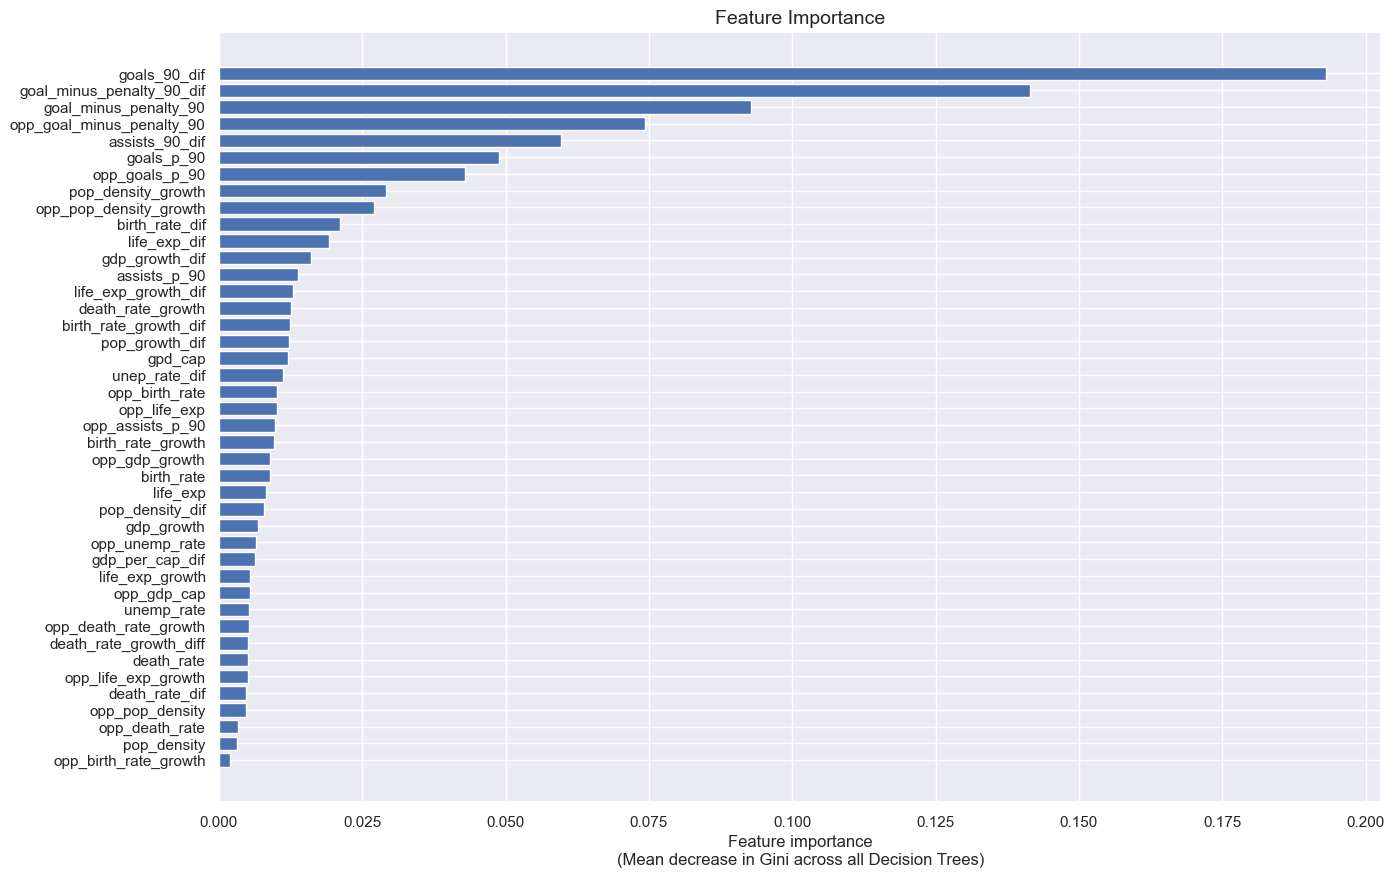

In [11]:
sns.set()
plot_feat_import(x_feat_list, rand_forest_clf.feature_importances_)


### Performance Factors

In [12]:
# football performance
# columns = ['team', 'year', 'round ', 'goals_p_90', 'opp_goals_p_90',
#            'goals_90_dif', 'assists_p_90', 'opp_assists_p_90', 'assists_90_dif',
#            'goal_minus_penalty_90', 'opp_goal_minus_penalty_90',
#            'goal_minus_penalty_90_dif', 'result']
columns = ['goal_minus_penalty_90_dif', 'goals_90_dif',
           'goal_minus_penalty_90', 'opp_goal_minus_penalty_90',
           'goals_p_90', 'result']

# extract performance data
df_perf = df_total.loc[:, columns]

# drop na's
df_perf = df_perf.dropna(how='any')

# scale normalization
for col in df_perf.columns[3:-1]:
    df_perf[col] = df_perf[col] / df_perf[col].std()
    
    
# params
x_feat_list = ['goal_minus_penalty_90_dif', 'goals_90_dif',
           'goal_minus_penalty_90', 'opp_goal_minus_penalty_90',
           'goals_p_90'] #df_perf.columns[3:-1]
target_feat = 'result'

# random forest classification
y, y_pred, rand_forest_clf = rf_cross_val(df_perf, x_feat_list, target_feat);


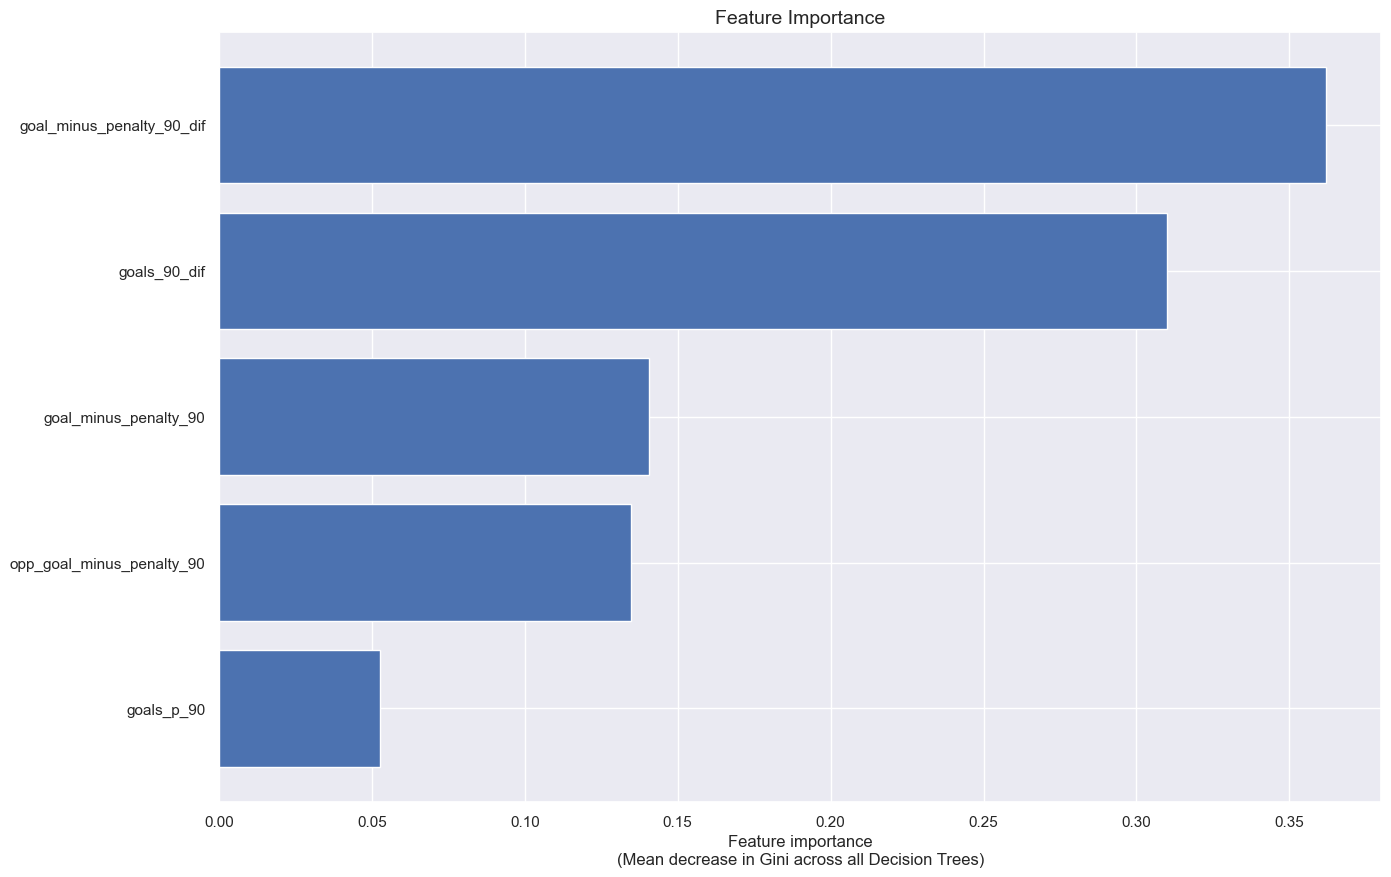

In [13]:
sns.set()
plot_feat_import(x_feat_list, rand_forest_clf.feature_importances_, limit=5)


### Socioeconomic Factors

In [14]:
# columns = ['gpd_cap', 'gdp_growth', 'pop_density',
#            'pop_density_growth', 'life_exp', 'life_exp_growth', 'birth_rate',
#            'birth_rate_growth', 'death_rate', 'death_rate_growth', 'unemp_rate',
#            'opp_gdp_cap', 'gdp_per_cap_dif', 'opp_gdp_growth', 'gdp_growth_dif',
#            'opp_pop_density', 'pop_density_dif', 'opp_pop_density_growth',
#            'pop_growth_dif', 'opp_life_exp', 'life_exp_dif', 'opp_life_exp_growth',
#            'life_exp_growth_dif', 'opp_birth_rate', 'birth_rate_dif',
#            'opp_birth_rate_growth', 'birth_rate_growth_dif', 'opp_death_rate',
#            'death_rate_dif', 'opp_death_rate_growth', 'death_rate_growth_diff',
#            'opp_unemp_rate', 'unep_rate_dif', 'result']
columns = ['birth_rate_dif','birth_rate',
           'opp_birth_rate', 'unep_rate_dif',
           'gdp_per_cap_dif', 'result']

# extract socioeconomic data
df_socio = df_total.loc[:, columns]

# drop na's
df_socio = df_socio.dropna(how='any')

# scale normalization
for col in df_socio.columns[3:-1]:
    df_socio[col] = df_socio[col] / df_socio[col].std()
    
# params
x_feat_list = ['birth_rate_dif','birth_rate',
           'opp_birth_rate', 'unep_rate_dif',
           'gdp_per_cap_dif'] # df_socio.columns[3:-1]
target_feat = 'result'

# random forest classification
y, y_pred, rand_forest_clf = rf_cross_val(df_socio, x_feat_list, target_feat);


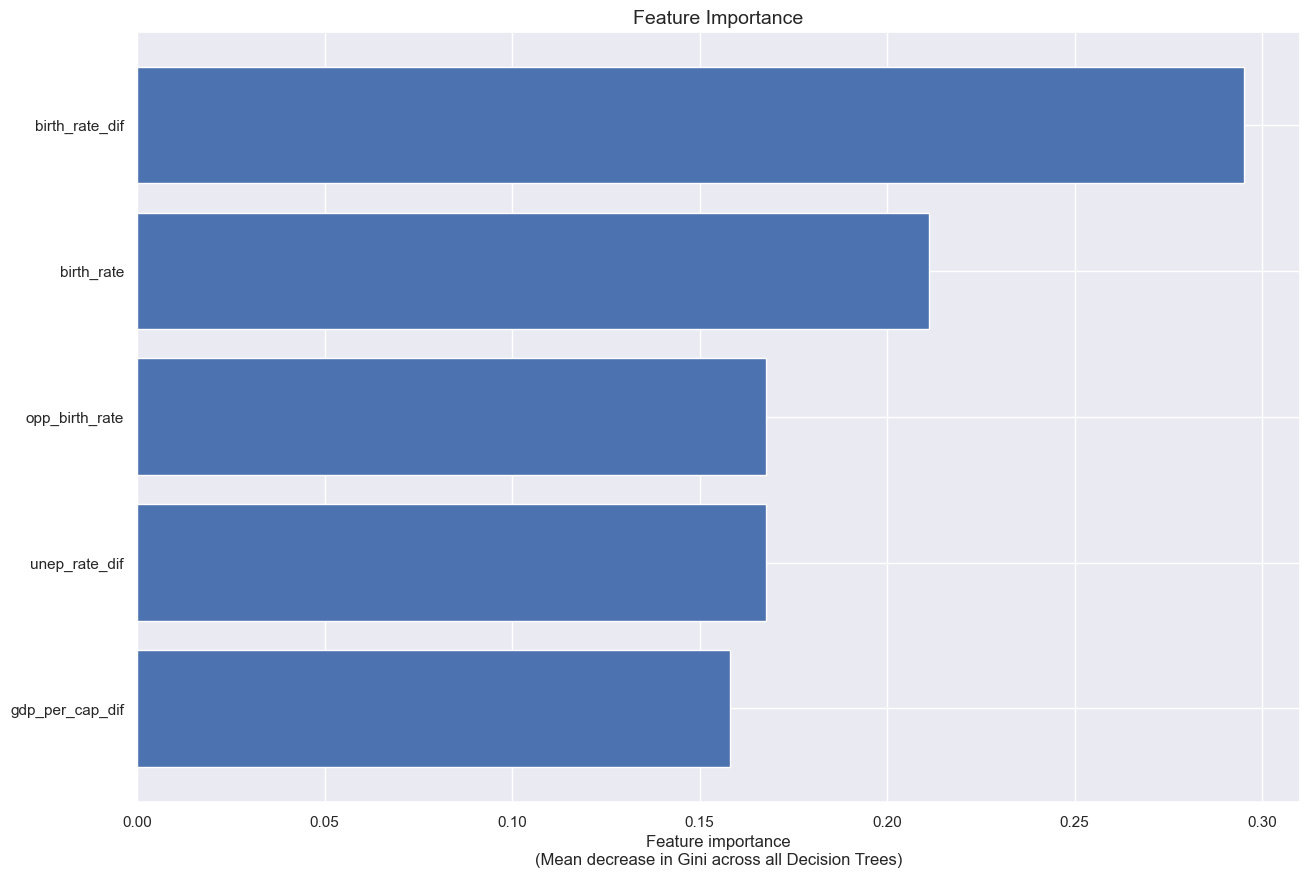

In [15]:
sns.set()
plot_feat_import(x_feat_list, rand_forest_clf.feature_importances_, limit=5)


# K-Nearest Neighbors

In [16]:
def knn_cross_val(df, x_feat_list, target_feat, k, n_splits=10):
    """ creates K-Nearest Neighbors object
            and cross-validates 
    
    Args:
        df (DataFrame): features and target feature data
        x_feat_list (list): list of features
        target_feat (str): target feature
        k (int): number of neighbors
        n_splits (n): number of splits for cross-validation
    Returns:
        y (np.array): true values
        y_pred (np.array): predicted values
    """
    # extract data from dataframe
    x = df.loc[:, x_feat_list].values
    y_true = df.loc[:, target_feat].values

    # initialize a knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # initialize an empty array same size as y_true
    y_pred = np.empty_like(y_true)

    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_idx, test_idx in k_fold.split(x, y_true):
        # get training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]

        # train on training data
        knn_classifier.fit(x_train, y_true_train)

        # estimate each bean's species
        y_pred[test_idx] = knn_classifier.predict(x_test)
        
    return y_true, y_pred

### Top Football Factors

In [17]:
# params
x_feat_list = ['goal_minus_penalty_90_dif', 'goals_90_dif',
               'goal_minus_penalty_90', 'opp_goal_minus_penalty_90',
               'goals_p_90']
target_feat = 'result'
k = 16

y_true, y_pred = knn_cross_val(df_perf, x_feat_list, target_feat, k)

In [18]:
accuracy_score(y_true=y_true, y_pred=y_pred)


0.7114285714285714

### Top Socioeconomic Factors

In [19]:
# params
x_feat_list = ['birth_rate_dif','birth_rate',
               'opp_birth_rate', 'unep_rate_dif',
               'gdp_per_cap_dif']

target_feat = 'result'

k_dict = {}
for k in range(1, 20):
    y_true, y_pred = knn_cross_val(df_total, x_feat_list, target_feat, k)
    score = accuracy_score(y_true=y_true, y_pred=y_pred)
    k_dict[k] = round(score, 2)
k_dict

{1: 0.65,
 2: 0.63,
 3: 0.61,
 4: 0.58,
 5: 0.57,
 6: 0.58,
 7: 0.58,
 8: 0.57,
 9: 0.59,
 10: 0.59,
 11: 0.62,
 12: 0.59,
 13: 0.59,
 14: 0.59,
 15: 0.57,
 16: 0.59,
 17: 0.59,
 18: 0.58,
 19: 0.58}

In [20]:
k = 11
y_true, y_pred = knn_cross_val(df_total, x_feat_list, target_feat, k)
score = accuracy_score(y_true=y_true, y_pred=y_pred)
accuracy_score(y_true=y_true, y_pred=y_pred)


0.5828571428571429

### Top Factors

In [21]:
# params
# x_feat_list = ['birth_rate_dif','birth_rate',
#                'opp_birth_rate', 'unep_rate_dif',
#                'gdp_per_cap_dif', 'goal_minus_penalty_90_dif', 'goals_90_dif',
#                'goal_minus_penalty_90', 'opp_goal_minus_penalty_90',
#                'goals_p_90']

x_feat_list = ['goal_minus_penalty_90_dif', 
'goals_90_dif',
'goals_p_90',
'opp_goals_p_90',
'goal_minus_penalty_90', 
'opp_goal_minus_penalty_90',
'assists_90_dif',
'pop_growth_dif',
'gdp_growth_dif',
'gdp_per_cap_dif']
target_feat = 'result'

k_dict = {}
for k in range(1, 25):
    y_true, y_pred = knn_cross_val(df_total, x_feat_list, target_feat, k)
    score = accuracy_score(y_true=y_true, y_pred=y_pred)
    k_dict[k] = round(score, 2)
k_dict

{1: 0.7,
 2: 0.69,
 3: 0.71,
 4: 0.71,
 5: 0.69,
 6: 0.72,
 7: 0.71,
 8: 0.71,
 9: 0.72,
 10: 0.71,
 11: 0.71,
 12: 0.71,
 13: 0.72,
 14: 0.73,
 15: 0.71,
 16: 0.71,
 17: 0.74,
 18: 0.72,
 19: 0.74,
 20: 0.73,
 21: 0.75,
 22: 0.73,
 23: 0.74,
 24: 0.73}

In [22]:
# params
x_feat_list = ['goal_minus_penalty_90_dif', 
'goals_90_dif',
'goals_p_90',
'opp_goals_p_90',
'goal_minus_penalty_90', 
'opp_goal_minus_penalty_90',
'assists_90_dif',
'pop_growth_dif',
'gdp_growth_dif',
'gdp_per_cap_dif']

target_feat = 'result'
k = 20

y_true, y_pred = knn_cross_val(df_total, x_feat_list, target_feat, k)
accuracy_score(y_true=y_true, y_pred=y_pred)


0.74

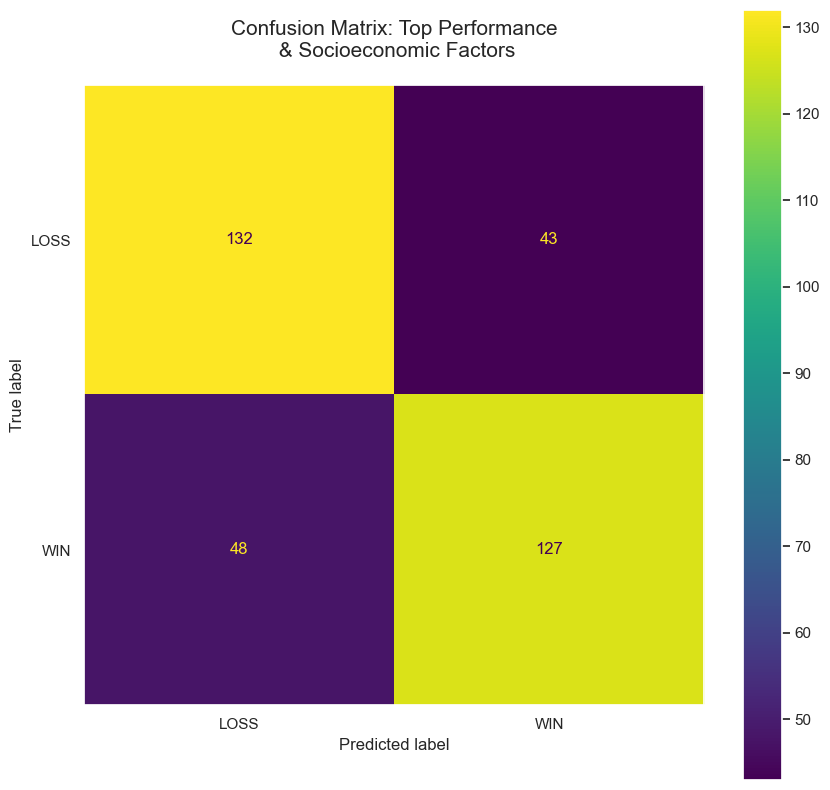

In [23]:
# build confusion matrix and plot it
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
conf_mat_disp.plot()
conf_mat_disp.ax_.set_title('Confusion Matrix: Top Performance\n & Socioeconomic Factors', 
                            fontdict={'fontsize': 15},
                            pad=20)
plt.gcf().set_size_inches(10, 10)
plt.grid(False)